# Simulation of IL-2 downstream TF perturbation

In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
import pandas as pd
work_dir = '/Users/jinhuixin/Master/thesis/GRN/BS1140_IL2_simulation/'

In [2]:
import dill
scplus_obj = dill.load(open('/Users/jinhuixin/Master/thesis/GRN/BS1140/scenicplus/scplus_obj_4Pando.pkl', 'rb'))

In [3]:
# import eR celltype
eR_celltype = pd.read_csv('/Users/jinhuixin/Master/thesis/GRN/BS1140/cluster_overlap/eRegulon_celltype.csv',index_col=0)
eR_celltype.head()

,eRegulon_cluster
ATTCCTCCATAATCAC-1-BS1140,1-SP1+MAFF+
TGAAACTGTTAGAGGG-1-BS1140,3-ETS1+ZNF282+
TTGACATCAGTTTGTG-1-BS1140,1-SP1+MAFF+
TGCACTTGTTAGGTGC-1-BS1140,1-SP1+MAFF+
CCCAAACCAGGCAAGC-1-BS1140,8-CREM-BACH2-


In [4]:
scplus_obj.metadata_cell['eR_celltype'] = eR_celltype.loc[scplus_obj.metadata_cell.index,:]

In [6]:
# celltype rna sct assay from seurat
rna_sct_celltype = pd.read_csv(work_dir + '../BS1140/intigrate_RNA_scenic+/bs1140_celltype_rna_sct_assay.csv', index_col=0)
rna_sct_celltype.index = rna_sct_celltype.index.str.replace('-1','-1-BS1140')

In [7]:
scplus_obj.metadata_cell['rna_sct_celltype'] = rna_sct_celltype.loc[scplus_obj.metadata_cell.index,:]

In [8]:
set(scplus_obj.metadata_cell['rna_sct_celltype'].values)

{'CMSS1+FILIP1L+',
 'Ex-ENTPD1+',
 'GNLY+IKZF2+',
 'GNLY+NKG7+',
 'IKZF2+PITPNC1+',
 'M-CD69+',
 'M-GZMK+',
 'M-IL7R+',
 'Naive-SESN3+',
 'Prol-STMN1+TOP2A+'}

calculate a target gene based PCA embedding to plot the perturbations on

In [9]:
# filter 
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'eR_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'eR_celltype',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'eR_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'eR_celltype',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

/Users/jinhuixin/miniconda3/envs/traj_sp_sc/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/Users/jinhuixin/miniconda3/envs/traj_sp_sc/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [10]:
# eR selection
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.50, 0.50],
        'n_targets': 0
}
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 35 eRegulons


# Plot perturbation effect on eR umap

In [11]:
from pycisTopic.diff_features import find_highly_variable_features
hvg = find_highly_variable_features(scplus_obj.to_df('EXP')[list(set(scplus_obj.uns['eRegulon_metadata_filtered']['Gene']))].T, n_top_features = 1000, plot = False)

2023-03-22 09:45:04,310 cisTopic     INFO     Calculating mean
2023-03-22 09:45:04,313 cisTopic     INFO     Calculating variance
2023-03-22 09:45:04,359 cisTopic     INFO     Done!


<Figure size 640x480 with 0 Axes>

In [12]:
import pandas as pd
eR_umap = pd.read_csv('/Users/jinhuixin/Master/thesis/GRN/BS1140/intigrate_RNA_scenic+/new_eR_umap_from_seurat.csv', index_col=0)
eR_umap.index = eR_umap.index.str.replace("-1", "-1-BS1140")

In [13]:
eR_umap = eR_umap.loc[scplus_obj.metadata_cell.index,:] # reorder

In [14]:
sum(eR_umap.index == scplus_obj.metadata_cell.index)

2546

In [15]:
scplus_obj.dr_cell['eRegulons_filtered_UMAP'] = eR_umap
scplus_obj.dr_cell['eRegulons_filtered_UMAP']

,UMAP_1,UMAP_2
ATTCCTCCATAATCAC-1-BS1140,-2.202525,-2.471173
TGAAACTGTTAGAGGG-1-BS1140,3.806863,-1.256704
TTGACATCAGTTTGTG-1-BS1140,-0.831632,-0.896572
TGCACTTGTTAGGTGC-1-BS1140,-0.957499,-1.384533
CCCAAACCAGGCAAGC-1-BS1140,-0.998289,4.043613
...,...,...
CGCATGATCCTCACTA-1-BS1140,-3.901073,3.039853
GCTTTCATCATCAGTA-1-BS1140,-3.786141,1.982912
AGCACTAGTACCGAAC-1-BS1140,-1.921470,-2.989782
GGGCAATAGGTAAGGC-1-BS1140,3.674478,-1.761493


In [16]:
# another reference umap
import pandas as pd
multiom_umap = pd.read_csv('/Users/jinhuixin/Master/thesis/BS1140/multiomics/bs1140_multiome_wnnumap.csv', index_col=0)
multiom_umap.index = multiom_umap.index.str.replace("lungc1140_","")
multiom_umap.index = multiom_umap.index.str.replace("-1", "-1-BS1140")

In [17]:
multiom_umap = multiom_umap.loc[scplus_obj.metadata_cell.index,:] # reorder

In [18]:
sum(multiom_umap.index == scplus_obj.metadata_cell.index)

2546

In [19]:
scplus_obj.dr_cell['multiom_UMAP'] = multiom_umap
scplus_obj.dr_cell['multiom_UMAP']

,wnnUMAP_1,wnnUMAP_2
ATTCCTCCATAATCAC-1-BS1140,1.397460,-4.034168
TGAAACTGTTAGAGGG-1-BS1140,-4.682788,-1.558833
TTGACATCAGTTTGTG-1-BS1140,1.667380,-1.264962
TGCACTTGTTAGGTGC-1-BS1140,1.493300,-1.549074
CCCAAACCAGGCAAGC-1-BS1140,1.543924,0.975982
...,...,...
CGCATGATCCTCACTA-1-BS1140,4.462180,-1.020504
GCTTTCATCATCAGTA-1-BS1140,2.381624,-0.971179
AGCACTAGTACCGAAC-1-BS1140,2.046132,-3.618706
GGGCAATAGGTAAGGC-1-BS1140,-4.707050,-1.147568


get STAT family eRs in dataset

In [20]:
scplus_obj.uns['eRegulon_AUC']['Gene_based'].columns[scplus_obj.uns['eRegulon_AUC']['Gene_based'].columns.str.startswith('STAT')]

Index(['STAT3_extended_+_+_(20g)', 'STAT2_extended_+_+_(22g)',
       'STAT2_+_+_(22g)', 'STAT1_+_-_(40g)', 'STAT3_+_+_(20g)',
       'STAT1_extended_+_+_(40g)', 'STAT1_extended_+_-_(40g)',
       'STAT1_+_+_(40g)'],
      dtype='object')

In [21]:
# proliferate cell group
prol_cells = scplus_obj.metadata_cell.index[scplus_obj.metadata_cell['rna_sct_celltype']=='Prol-STMN1+TOP2A+']

### STAT1

expression level in all cells

In [22]:
scplus_obj.to_df('EXP').loc[:,'STAT1'].describe()

count    2546.000000
mean        0.326881
std         0.666955
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.149135
Name: STAT1, dtype: float64

expression level in proliferate cells

In [23]:
scplus_obj.to_df('EXP').loc[prol_cells,'STAT1'].describe()

count    51.000000
mean      0.624363
std       0.792695
min       0.000000
25%       0.000000
50%       0.000000
75%       1.066896
max       3.002646
Name: STAT1, dtype: float64

In [24]:
color_dict_line_eR = {
    "0-ZSCAN22+EOMES+":"#8DD3C7", 
    "1-SP1+MAFF+":"#FFFFB3", 
    "2-FOXP1+ARID5B+":"#BEBADA", 
    "3-ETS1+ZNF282+":"#FB8072", 
    "4-ZNF442+ZNF526+":"#80B1D3", 
    "5-TBX21+RARG+":"#FDB462", 
    "6-CREM-ELF1+":"#B3DE69", 
    "7-ZNF385D+RORC+":"#FCCDE5", 
    "8-CREM-BACH2-":"#D9D9D9",
    "9-EGR1+FOSB+":"#BC80BD"
}
color_dict_line_rna = {
    'CMSS1+FILIP1L+':"#8DD3C7",
    'Ex-ENTPD1+':"#FFFFB3",
    'GNLY+IKZF2+':"#BEBADA",
    'GNLY+NKG7+':"#FB8072",
    'IKZF2+PITPNC1+':"#80B1D3",
    'M-CD69+':"#FDB462",
    'M-GZMK+':"#B3DE69",
    'M-IL7R+':"#FCCDE5",
    'Naive-SESN3+':"#D9D9D9",
    'Prol-STMN1+TOP2A+':"#BC80BD"
}

2023-03-23 11:40:37,007 perturbation INFO     Caclulating perturbation matrix for: {'STAT1': 0.62} over 5 iterations.


100%|██████████| 999/999 [03:16<00:00,  5.09it/s]


2023-03-23 11:44:58,691 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 11:45:03,841 perturbation INFO     Scoring eRegulons.
2023-03-23 11:45:12,207 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 11:45:12,712 perturbation INFO     Calculating grid of arrows
2023-03-23 11:45:12,754 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


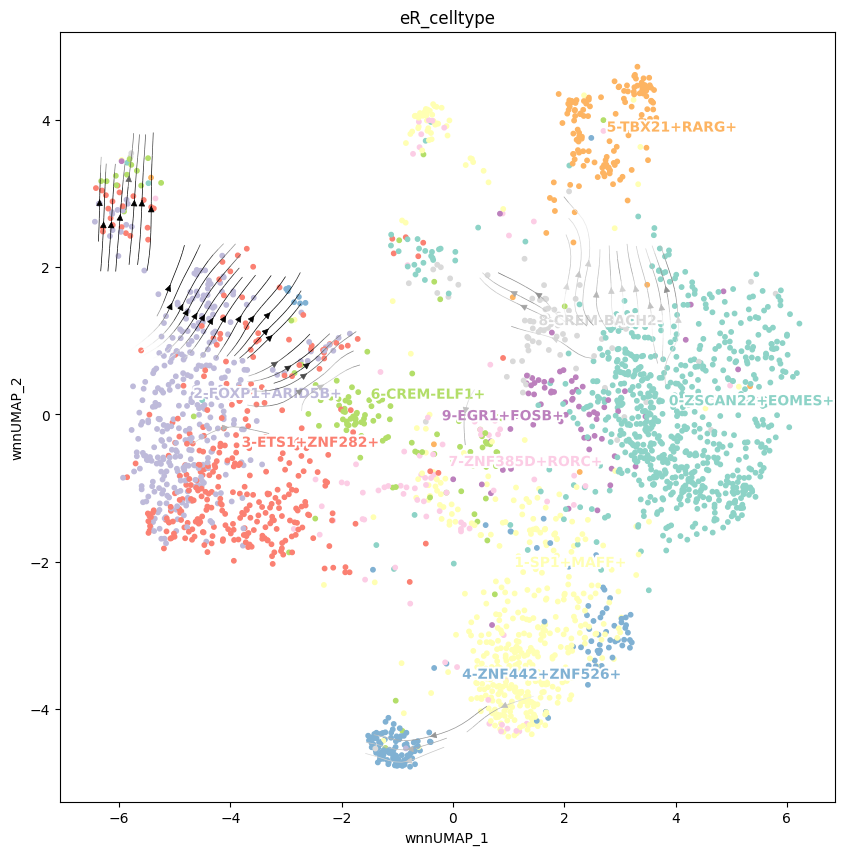

In [40]:
from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT1':0.62}, #set the expression of STAT1 to 0.6 in all cells.
    variable='eR_celltype',
    color_dictionary = {'eR_celltype':color_dict_line_eR},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT1_up_eR_celltype_multiom_umap.pdf'
)

2023-03-23 11:46:32,621 perturbation INFO     Caclulating perturbation matrix for: {'STAT1': 0.62} over 5 iterations.


100%|██████████| 999/999 [03:09<00:00,  5.26it/s]


2023-03-23 11:50:46,864 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 11:50:51,514 perturbation INFO     Scoring eRegulons.
2023-03-23 11:50:59,976 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 11:51:00,615 perturbation INFO     Calculating grid of arrows
2023-03-23 11:51:00,658 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


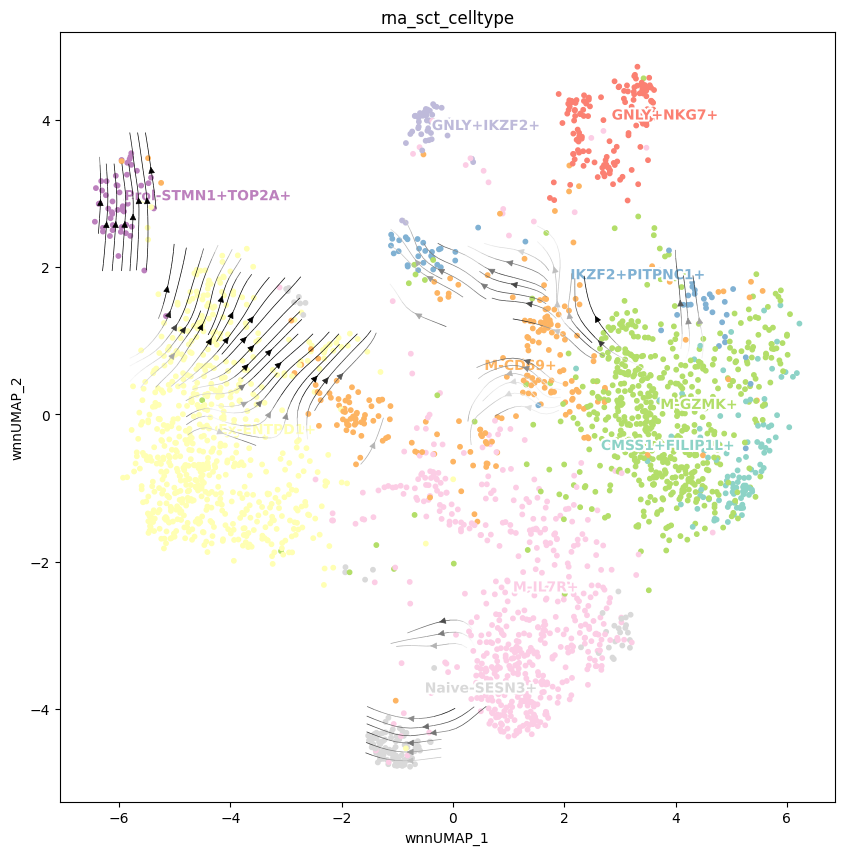

In [41]:
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT1':0.62}, #set the expression of STAT1 to 0.6 in all cells.
    variable='rna_sct_celltype',
    color_dictionary = {'rna_sct_celltype':color_dict_line_rna},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT1_up_rna_sct_celltype_multiom_umap.pdf'
)

### STAT3

In [ ]:
scplus_obj.to_df('EXP').loc[:,'STAT3'].describe()

count    2546.000000
mean        1.190766
std         1.040857
min         0.000000
25%         0.000000
50%         1.414468
75%         2.024768
max         3.823033
Name: STAT3, dtype: float64

In [ ]:
scplus_obj.to_df('EXP').loc[prol_cells,'STAT3'].describe()

count    51.000000
mean      1.175659
std       0.859301
min       0.000000
25%       0.000000
50%       1.382556
75%       1.735044
max       2.891687
Name: STAT3, dtype: float64

2023-03-23 11:54:04,817 perturbation INFO     Caclulating perturbation matrix for: {'STAT3': 1.18} over 5 iterations.


100%|██████████| 999/999 [03:15<00:00,  5.11it/s]


2023-03-23 11:58:03,679 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 11:58:08,058 perturbation INFO     Scoring eRegulons.
2023-03-23 11:58:15,827 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 11:58:16,307 perturbation INFO     Calculating grid of arrows
2023-03-23 11:58:16,348 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


2023-03-23 11:58:18,125 perturbation INFO     Caclulating perturbation matrix for: {'STAT3': 1.18} over 5 iterations.


100%|██████████| 999/999 [03:06<00:00,  5.35it/s]


2023-03-23 12:02:06,121 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 12:02:10,602 perturbation INFO     Scoring eRegulons.
2023-03-23 12:02:18,550 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 12:02:19,043 perturbation INFO     Calculating grid of arrows
2023-03-23 12:02:19,085 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


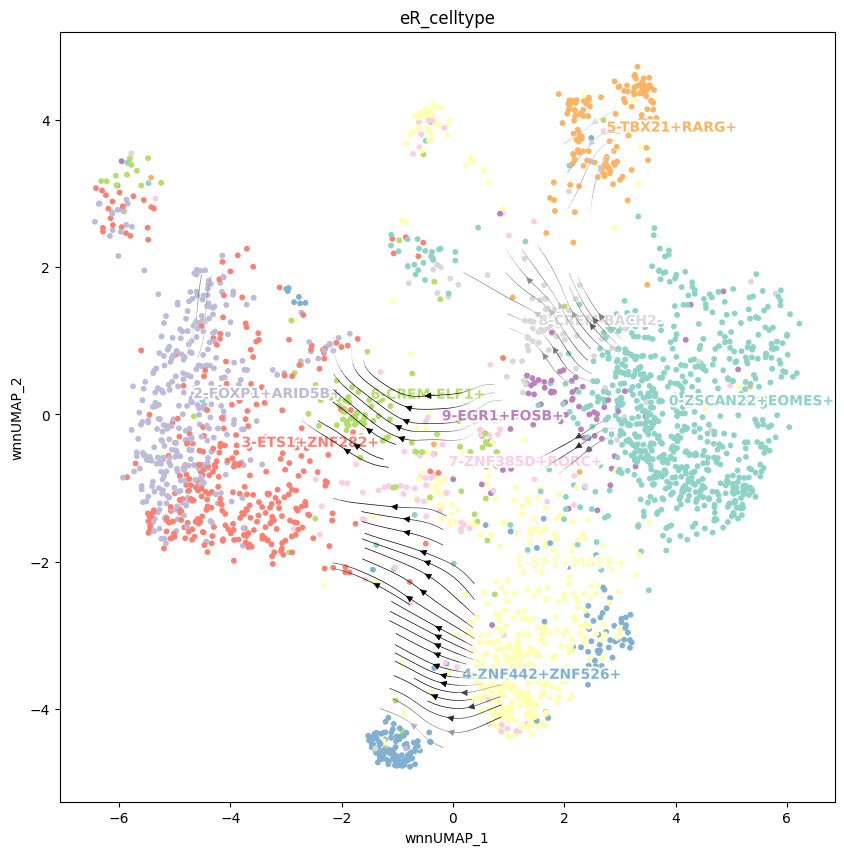

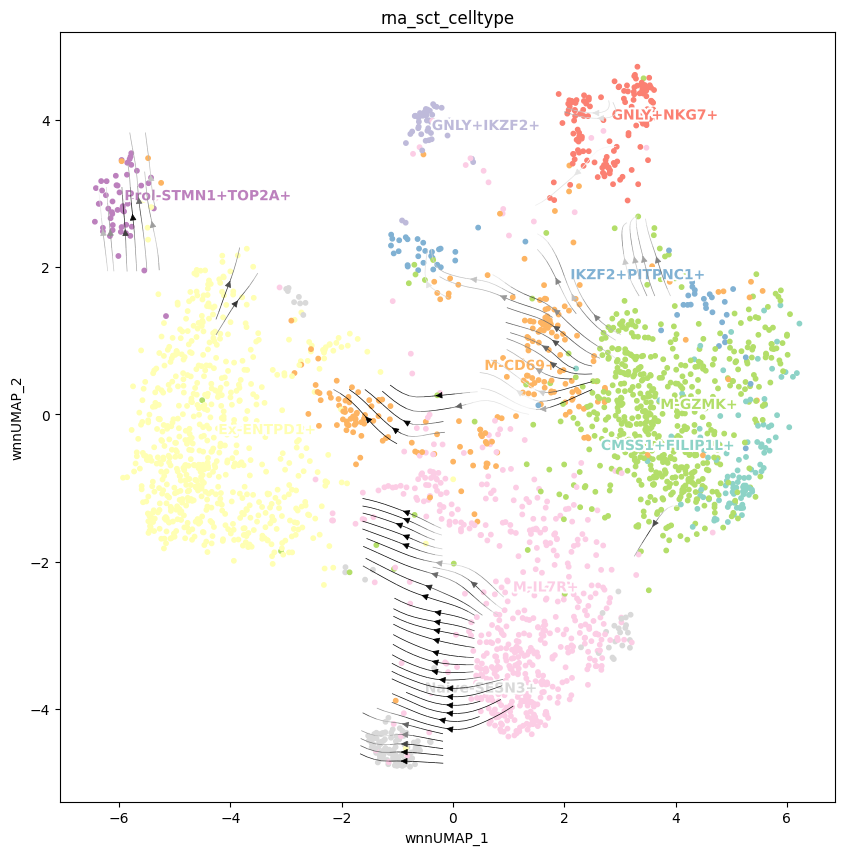

In [42]:
from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT3':1.18}, #set the expression of STAT1 to 0.6 in all cells.
    variable='eR_celltype',
    color_dictionary = {'eR_celltype':color_dict_line_eR},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT3_up_eR_celltype_multiom_umap.pdf'
)
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT3':1.18}, #set the expression of STAT1 to 0.6 in all cells.
    variable='rna_sct_celltype',
    color_dictionary = {'rna_sct_celltype':color_dict_line_rna},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT3_up_rna_sct_celltype_multiom_umap.pdf'
)

### STAT5A

In [ ]:
scplus_obj.to_df('EXP').loc[:,'STAT5A'].describe()

count    2546.000000
mean        0.538938
std         0.834291
min         0.000000
25%         0.000000
50%         0.000000
75%         1.328677
max         3.652181
Name: STAT5A, dtype: float64

In [ ]:
scplus_obj.to_df('EXP').loc[prol_cells,'STAT5A'].describe()

count    51.000000
mean      0.659209
std       0.754268
min       0.000000
25%       0.000000
50%       0.000000
75%       1.333591
max       2.231512
Name: STAT5A, dtype: float64

In [39]:
# export perturbation exp and eR matrix
from scenicplus.simulation import simulate_perturbation, _make_rankings, score_eRegulons
perturbed_matrix = simulate_perturbation(
    scplus_obj = scplus_obj,
    perturbation = {'STAT5A':2.23}, 
    n_iter = 5, 
    genes = hvg,  
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    keep_intermediate = False
)
perturbed_matrix.to_csv(work_dir + 'STAT5A_changed_exp_matrix.csv')
perturbed_ranking = _make_rankings(perturbed_matrix)
perturbed_matrix = score_eRegulons(
            scplus_obj = scplus_obj,
            ranking = perturbed_ranking,
            enrichment_type = 'gene',
            inplace = False,
            eRegulon_signatures_key = 'eRegulon_signatures_filtered',
            key_added = 'eRegulon_AUC_filtered',
            n_cpu = 7)
perturbed_matrix.to_csv(work_dir + 'STAT5A_changed_eR_matrix.csv')

100%|██████████| 999/999 [03:14<00:00,  5.14it/s]


2023-03-22 16:35:06,196 perturbation INFO     Caclulating perturbation matrix for: {'STAT5A': 2.23} over 5 iterations.


100%|██████████| 999/999 [03:03<00:00,  5.43it/s]


2023-03-22 16:38:12,907 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-22 16:38:17,371 perturbation INFO     Scoring eRegulons.
2023-03-22 16:38:24,672 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-22 16:38:25,161 perturbation INFO     Calculating grid of arrows
2023-03-22 16:38:25,203 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


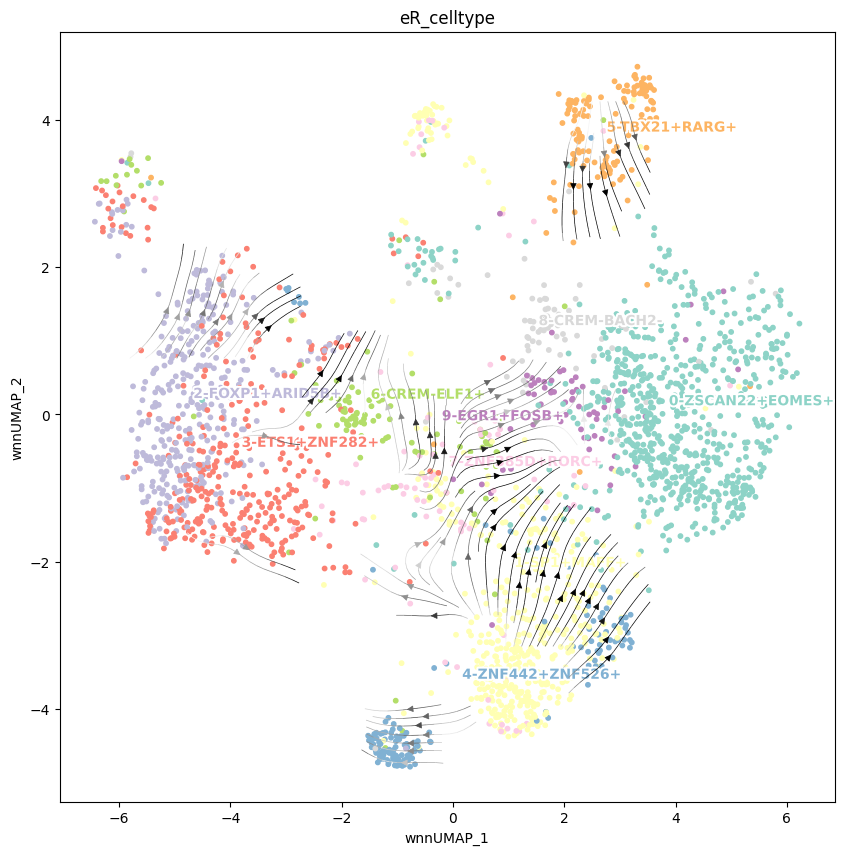

2023-03-22 16:38:26,964 perturbation INFO     Caclulating perturbation matrix for: {'STAT5A': 2.23} over 5 iterations.


100%|██████████| 999/999 [03:10<00:00,  5.23it/s]


2023-03-22 16:41:40,538 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-22 16:41:45,032 perturbation INFO     Scoring eRegulons.
2023-03-22 16:41:52,438 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-22 16:41:52,922 perturbation INFO     Calculating grid of arrows
2023-03-22 16:41:52,963 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


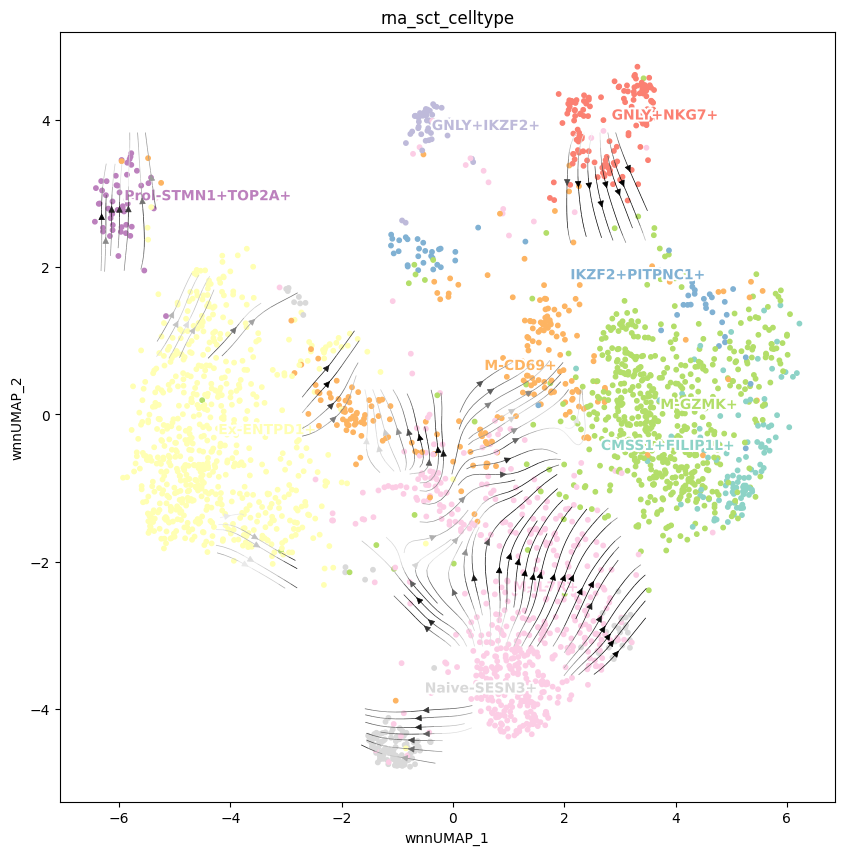

In [35]:
from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT5A':2.23}, #set the expression of STAT1 to 0.6 in all cells.
    variable='eR_celltype',
    color_dictionary = {'eR_celltype':color_dict_line_eR},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered'
    #save = './STAT5A_up_up_eR_celltype_multiom_umap.pdf'
)
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT5A':2.23}, #set the expression of STAT1 to 0.6 in all cells.
    variable='rna_sct_celltype',
    color_dictionary = {'rna_sct_celltype':color_dict_line_rna},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered'
    #save = './STAT5A_up_up_rna_sct_celltype_multiom_umap.pdf'
)

### STAT5B

In [ ]:
scplus_obj.to_df('EXP').loc[:,'STAT5B'].describe()

count    2546.000000
mean        0.977109
std         1.046095
min         0.000000
25%         0.000000
50%         0.976372
75%         1.846276
max         3.973568
Name: STAT5B, dtype: float64

In [ ]:
scplus_obj.to_df('EXP').loc[prol_cells,'STAT5B'].describe()

count    51.000000
mean      1.276088
std       0.957149
min       0.000000
25%       0.000000
50%       1.377435
75%       1.857108
max       2.959621
Name: STAT5B, dtype: float64

2023-03-23 12:02:48,380 perturbation INFO     Caclulating perturbation matrix for: {'STAT5B': 1.28} over 5 iterations.


100%|██████████| 999/999 [03:12<00:00,  5.20it/s]


2023-03-23 12:06:03,472 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 12:06:07,848 perturbation INFO     Scoring eRegulons.
2023-03-23 12:06:15,717 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 12:06:16,204 perturbation INFO     Calculating grid of arrows
2023-03-23 12:06:16,247 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


2023-03-23 12:06:18,046 perturbation INFO     Caclulating perturbation matrix for: {'STAT5B': 1.28} over 5 iterations.


100%|██████████| 999/999 [03:08<00:00,  5.30it/s]


2023-03-23 12:09:29,407 perturbation INFO     Generating ranking based on perturbed matrix.
2023-03-23 12:09:34,048 perturbation INFO     Scoring eRegulons.
2023-03-23 12:09:41,854 perturbation INFO     Projecting perturbation effect in embedding: multiom_UMAP
2023-03-23 12:09:42,346 perturbation INFO     Calculating grid of arrows
2023-03-23 12:09:42,387 perturbation INFO     Plotting


/Users/jinhuixin/Downloads/scenicplus/src/scenicplus/simulation.py:292: RuntimeWarning: invalid value encountered in divide
  unitary_vectors /= np.linalg.norm(unitary_vectors, ord=2, axis=0)  # divide by L2


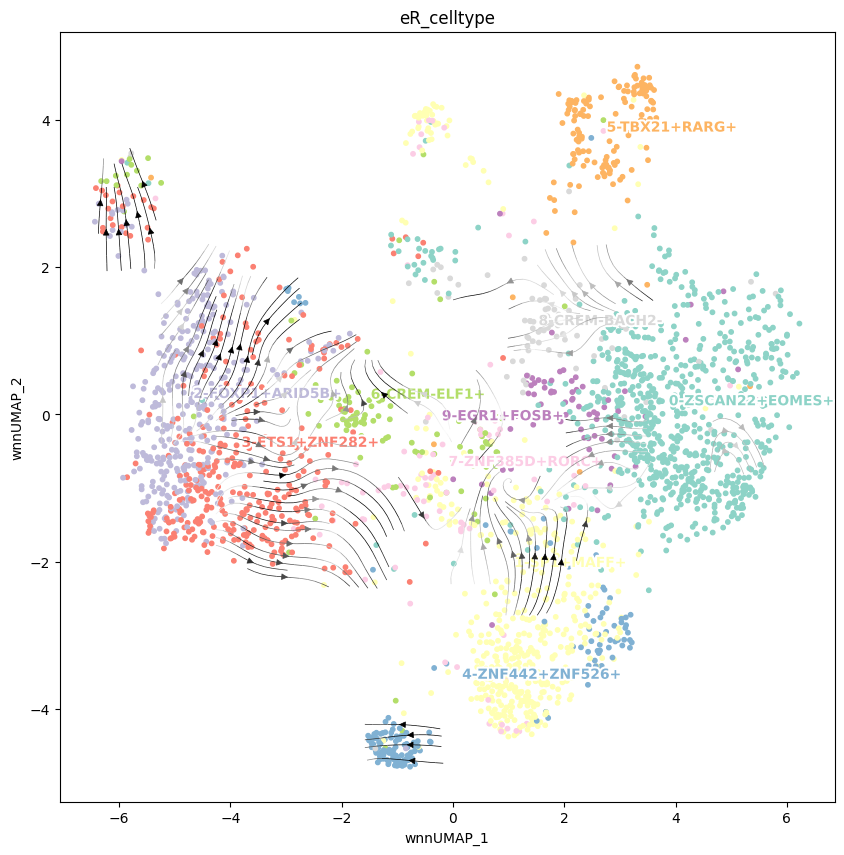

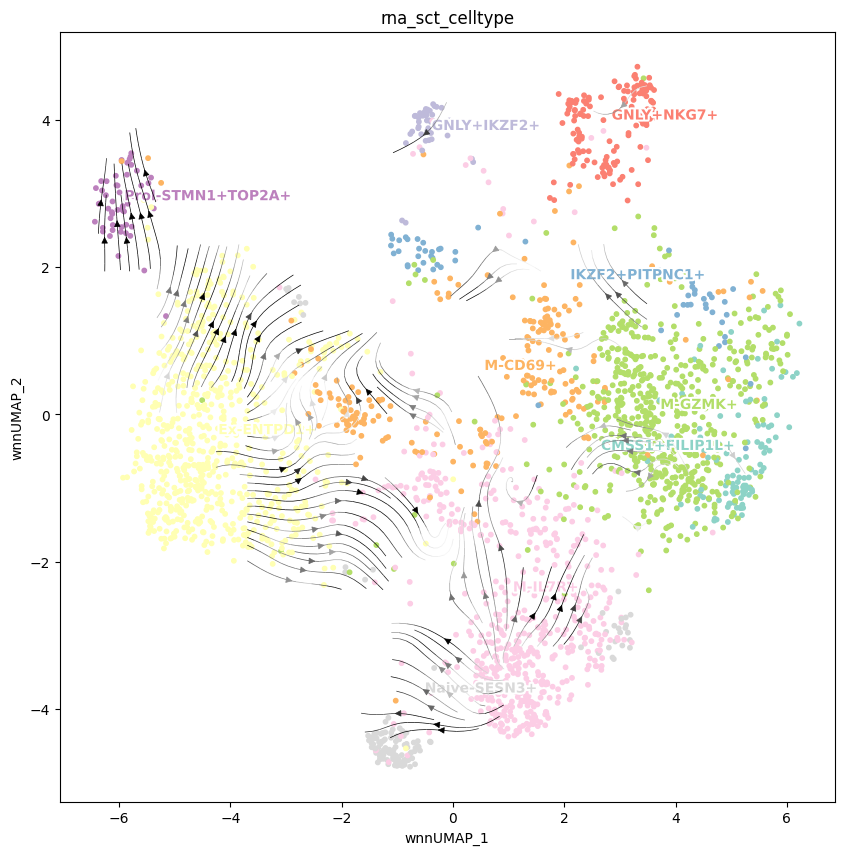

In [43]:
from scenicplus.simulation import plot_perturbation_effect_in_embedding
import seaborn as sns
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT5B':1.28}, #set the expression of STAT1 to 0.6 in all cells.
    variable='eR_celltype',
    color_dictionary = {'eR_celltype':color_dict_line_eR},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT5B_up_eR_celltype_multiom_umap.pdf'
)
fig = plot_perturbation_effect_in_embedding(
    scplus_obj,
    reduction_name='multiom_UMAP',
    n_cpu = 7,
    perturbation= {'STAT5B':1.28}, #set the expression of STAT1 to 0.6 in all cells.
    variable='rna_sct_celltype',
    color_dictionary = {'rna_sct_celltype':color_dict_line_rna},
    genes_to_use=hvg,
    figsize=(10,10),
    eRegulon_metadata_key='eRegulon_metadata_filtered',
    AUC_key = 'eRegulon_AUC_filtered',
    eRegulon_signatures_key = 'eRegulon_signatures_filtered',
    save = work_dir + 'STAT5B_up_rna_sct_celltype_multiom_umap.pdf'
)